In [2]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Candice's Code

In [2]:
cars = '../data/vehicle-fuel-type-count-by-zip-code.csv'
geocodes = '../data/fips_zip_correct.csv'
cars_data = pd.read_csv(cars)
geocodes = pd.read_csv(geocodes)
geocodes1 = geocodes[geocodes['State'] == 6]
geocodes1.nunique()

zip       2448
State        1
County      58
dtype: int64

In [3]:
cars_data.nunique()

Date             1
Zip Code      2915
Model Year      15
Fuel             9
Make           113
Duty             2
Vehicles      2375
dtype: int64

In [4]:
print('the length of the car data is ' + str(len(cars_data)))
print('the number of cars in cars data is ' + str(cars_data['Vehicles'].sum()))

the length of the car data is 584338
the number of cars in cars data is 30411713


In [5]:
#getting the number of zips per county, by grouping by zip and then counting number of counties
geocodes = geocodes1.rename(columns = {'zip': 'Zip Code', 'County':'COUNTY'})
n_zip_county = geocodes.groupby('Zip Code').count().sort_values(['COUNTY'],ascending = False).reset_index()

#creating weights by doing 1/n
n_zip_county['Weights'] = 1/n_zip_county['COUNTY']
n_zip_county.head()

,Zip Code,State,COUNTY,Weights
0,93252,4,4,0.250000
1,95645,3,3,0.333333
2,95329,3,3,0.333333
3,95960,3,3,0.333333
4,95690,3,3,0.333333


In [6]:
#renaming zip code for merge
cars_data =cars_data.rename(columns={'Zip Code': 'Zip Code'})

#reducing zip codes to just zip code and weights
n_zip_county = n_zip_county[['Zip Code','Weights']].sort_values(['Zip Code'])
n_zip_county.head()

,Zip Code,Weights
1250,90001,1.0
2071,90002,1.0
1647,90003,1.0
1648,90004,1.0
1649,90005,1.0


In [7]:
#mapping n_zips back into geocodes
geocodes_weights = pd.merge(geocodes,n_zip_county,
                            on = 'Zip Code',how = 'inner')
geocodes_weights.head()

,Zip Code,State,COUNTY,Weights
0,90016,6,37,1.0
1,90026,6,37,1.0
2,90018,6,37,1.0
3,96161,6,61,0.5
4,96161,6,57,0.5


In [8]:
#merging weights/number of car regristrations by zip code into fips code
cars_merge_county = pd.merge(cars_data, geocodes_weights, how="inner", on=["Zip Code"])
cars_merge_county.sort_values(['Weights']).nunique()

Date             1
Zip Code      2376
Model Year      15
Fuel             9
Make           113
Duty             2
Vehicles      2375
State            1
COUNTY          58
Weights          4
dtype: int64

In [9]:
#multiplying the weights by number of vehicles
cars_merge_county['Adj Veh'] = cars_merge_county['Vehicles']*cars_merge_county['Weights']

cars_merge_county.sort_values(['Weights'], ascending = True).head(2)
cars_merge_county['Zip Code'].nunique()

2376

In [10]:
sum_cars = cars_merge_county[['Vehicles','Adj Veh','Fuel','COUNTY']].groupby(['Fuel','COUNTY']).sum().rename(columns = {'Vehicles':'Veh','Adj Veh': 'N Adj Veh'}).reset_index()


difference = round(cars_data['Vehicles'].sum() - sum_cars['N Adj Veh'].sum())
percentage = round(difference/cars_data['Vehicles'].sum(),4)

print('the original number of cars is ' + str(cars_data['Vehicles'].sum()))
print('The number of unadjusted vehicles are ' + str(round(sum_cars['Veh'].sum())))
print('The number of adjusted vehicles are ' + str(round(sum_cars['N Adj Veh'].sum())))
print('The difference between the original cars and the adjusted cars is ' + str(difference))
print('The percentage of this change is '+ str(percentage) + ' of the data')

sum_cars.head()

the original number of cars is 30411713
The number of unadjusted vehicles are 33859585
The number of adjusted vehicles are 30386851.0
The difference between the original cars and the adjusted cars is 24862.0
The percentage of this change is 0.0008 of the data


,Fuel,COUNTY,Veh,N Adj Veh
0,Battery Electric,1,20771,17641.333333
1,Battery Electric,3,12,6.000000
2,Battery Electric,5,52,47.000000
3,Battery Electric,7,308,260.000000
4,Battery Electric,9,96,85.833333


In [11]:
cars_by_county = cars_merge_county[['Vehicles','Adj Veh','COUNTY']].groupby('COUNTY').sum().rename(columns = {'Vehicles':'tot Veh count','Adj Veh':'tot Adj Veh count'})
print('The number of counties after the merge are ' + str(len(cars_by_county)))
cars_by_county.head()

The number of counties after the merge are 58


,tot Veh count,tot Adj Veh count
COUNTY,,
1,1336960,1.162061e+06
3,6571,3.777000e+03
5,43471,3.934100e+04
7,205230,1.606690e+05
9,62906,5.695833e+04


In [12]:
cars_percentage = pd.merge(sum_cars, cars_by_county,
                           how = 'left', on = 'COUNTY')
cars_percentage['percentage unadjusted'] = cars_percentage['Veh']/cars_percentage['tot Veh count']
cars_percentage['percentage adjusted'] = cars_percentage['N Adj Veh']/cars_percentage['tot Adj Veh count']


cars_percentage = cars_percentage[['Fuel','COUNTY','percentage unadjusted','percentage adjusted']]
cars_percentage.sort_values('COUNTY').set_index('COUNTY').head()

,Fuel,percentage unadjusted,percentage adjusted
COUNTY,,,
1,Battery Electric,0.015536,0.015181
1,Diesel and Diesel Hybrid,0.031110,0.030150
1,Natural Gas,0.000993,0.001050
1,Other,0.000165,0.000175
1,Hydrogen Fuel Cell,0.000258,0.000257


In [13]:

#manually transposing percentages to type percentage
batt_elect = cars_percentage.loc[cars_percentage['Fuel'] == 'Battery Electric']
batt_elect = batt_elect.rename(columns = {'percentage unadjusted': 'Battery Electric % Unadj', 'percentage adjusted': 'Battery Electric % adj'}).drop(columns = 'Fuel')


hybrid = cars_percentage.loc[cars_percentage['Fuel'] == 'Hybrid Gasoline']
hybrid = hybrid.rename(columns = {'percentage unadjusted': 'Hybrid Gasoline % Unadj', 'percentage adjusted': 'Hybrid Gasoline % adj'}).drop(columns = 'Fuel')

plug = cars_percentage.loc[cars_percentage['Fuel'] == 'Battery Electric']
plug = plug.rename(columns = {'percentage unadjusted': 'Plug Electric % Unadj', 'percentage adjusted': 'Plug Electric % adj'}).drop(columns = 'Fuel')


#merging back together on county code
bat_hy = pd.merge(batt_elect, hybrid,
                 how = 'right', on ='COUNTY')
final = pd.merge(bat_hy, plug,
                how = 'left', on = 'COUNTY')

final['% Unadj Low Emission'] = final['Battery Electric % Unadj'] + final['Hybrid Gasoline % Unadj'] + final['Plug Electric % Unadj']
final['% Adj Low Emission'] = final['Battery Electric % adj'] + final['Hybrid Gasoline % adj'] + final['Plug Electric % adj']

top_5_evs = final.sort_values('% Adj Low Emission', ascending = False).head(5)
top_5_count = top_5_evs['COUNTY']
top_5_count.tolist()

low_5_evs = final.sort_values('% Adj Low Emission', ascending = True).head(5)
low_5_count = low_5_evs['COUNTY']



print('The top 5 County Codes are ' + str(top_5_count.tolist()))
print('the bottom 5 County Codes are ' + str(low_5_count.tolist()))

final.head()

The top 5 County Codes are [75, 41, 85, 81, 1]
the bottom 5 County Codes are [35, 49, 63, 25, 21]


,COUNTY,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,1,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728
1,3,0.001826,0.001589,0.016284,0.016283,0.001826,0.001589,0.019936,0.019460
2,5,0.001196,0.001195,0.017230,0.017539,0.001196,0.001195,0.019622,0.019928
3,7,0.001501,0.001618,0.022536,0.023527,0.001501,0.001618,0.025537,0.026763
4,9,0.001526,0.001507,0.017629,0.018075,0.001526,0.001507,0.020682,0.021089


In [14]:
#exporting to CSV
final.to_csv('../data/electric_vehicle_county.csv')

In [15]:
#importing asthma and county - county codes data
#importing pollution data
file = os.path.join('../data/asthma_ed_2011_2017.csv')
file2 = os.path.join('../data/geocodes.csv')
file3 = os.path.join('../data/AIR_DATA.csv')
#renaming columns to match with asthma data
fips = pd.read_csv(file2).rename(columns = {'Area Name (including legal/statistical area description)':'Geography',
                                           'County Code (FIPS)':'COUNTY'})
ed = pd.read_csv(file)


In [16]:
#removing California State row from asthma data
ed_county = ed.loc[ed['Geography'] != 'California']

#reducing FIPS data to only California (state code = 6)
fips_cali = fips.loc[fips['State Code (FIPS)'] == 6]

In [17]:
#adding in county text to asthma data to match FIPS data
ed_county['Geography'] = (ed_county['Geography'] + ' County')

#merging left join
ed1 = pd.merge(ed_county, fips_cali,
              on = 'Geography', how = 'left')
ed1.head()


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Geography,Year,Age Group,Strata,Strata Name,Numerator,Percent,Summary Level,State Code (FIPS),COUNTY,County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS)
0,Alameda County,2011,18 and Over,Total Population,18 and Over,"6,706",56.6,50.0,6.0,1.0,0.0,0.0,0.0
1,Amador County,2011,18 and Over,Total Population,18 and Over,162,58.1,50.0,6.0,5.0,0.0,0.0,0.0
2,Butte County,2011,18 and Over,Total Population,18 and Over,807,49.9,50.0,6.0,7.0,0.0,0.0,0.0
3,Calaveras County,2011,18 and Over,Total Population,18 and Over,156,49.5,50.0,6.0,9.0,0.0,0.0,0.0
4,Colusa County,2011,18 and Over,Total Population,18 and Over,34,23.4,50.0,6.0,11.0,0.0,0.0,0.0


In [18]:
#reducing asthma data to all ages and total population
ed2 = ed1.loc[(ed1['Age Group'] == 'All Ages') &
                (ed1['Strata'] == 'Total Population')]
reduced = ed2[['Year','COUNTY','Geography','Percent']]
reduced

,Year,COUNTY,Geography,Percent
361,2011,1.0,Alameda County,61.6
362,2011,5.0,Amador County,66.7
363,2011,7.0,Butte County,53.5
364,2011,9.0,Calaveras County,58.4
365,2011,11.0,Colusa County,30.1
...,...,...,...,...
7200,2017,107.0,Tulare County,43.4
7201,2017,109.0,Tuolumne County,53.6
7202,2017,111.0,Ventura County,34.8
7203,2017,113.0,Yolo County,43.3


In [19]:
#pulling out top 5 counties for EVs
top_5_ed = reduced[reduced.COUNTY.isin(top_5_count)].drop(columns = 'COUNTY')
top_5_ed.head(5)

,Year,Geography,Percent
361,2011,Alameda County,61.6
380,2011,Marin County,31.2
397,2011,San Francisco County,44.1
400,2011,San Mateo County,39.1
402,2011,Santa Clara County,31.9


In [20]:
#pulling out lowest 5 counties for EVs
low_5_ed = reduced[reduced.COUNTY.isin(low_5_count)].drop(columns = 'COUNTY')
low_5_ed.head(5)

,Year,Geography,Percent
370,2011,Glenn County,43.3
372,2011,Imperial County,76.4
377,2011,Lassen County,32.7
384,2011,Modoc County,59.1
391,2011,Plumas County,54.2


In [21]:
#changing data to pivot, for easier graphing 
pivot_high=top_5_ed.pivot(index='Year',columns='Geography')
pivot_low = low_5_ed.pivot(index = 'Year', columns = 'Geography')
pivot_low

Percent                                             \
Geography Glenn County Imperial County Lassen County Modoc County   
Year                                                                
2011              43.3            76.4          32.7         59.1   
2012              37.4            77.9          32.2         60.0   
2013              44.1            67.6          34.3         51.9   
2014              37.7            79.9          34.3         78.0   
2015              42.6            71.2          45.3         67.9   
2016              36.3            66.3          40.7         80.1   
2017              45.6            65.7          44.0        106.0   

                         
Geography Plumas County  
Year                     
2011               54.2  
2012               46.4  
2013               54.7  
2014               42.0  
2015               56.3  
2016               61.4  
2017               63.2

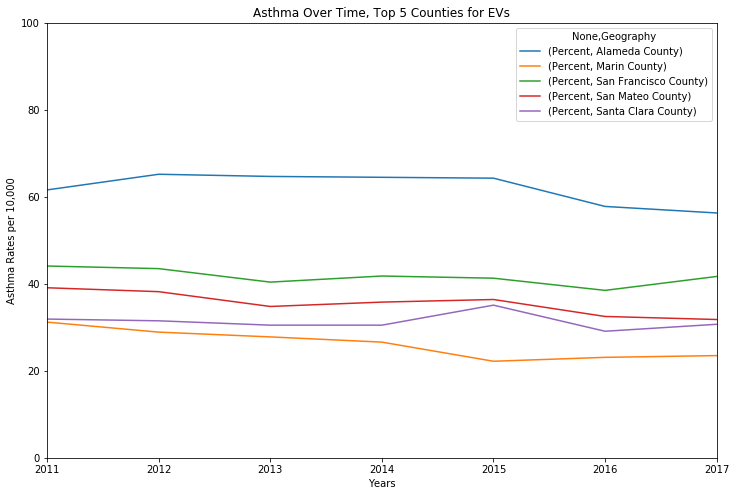

In [22]:
#graphing each county over time

pivot_high.plot(kind='line', figsize=(12,8))
plt.ylim(0,100)
plt.title('Asthma Over Time, Top 5 Counties for EVs')
plt.xlabel('Years')
plt.ylabel('Asthma Rates per 10,000')

plt.savefig('../output/top_5_asthma.png')

plt.show()

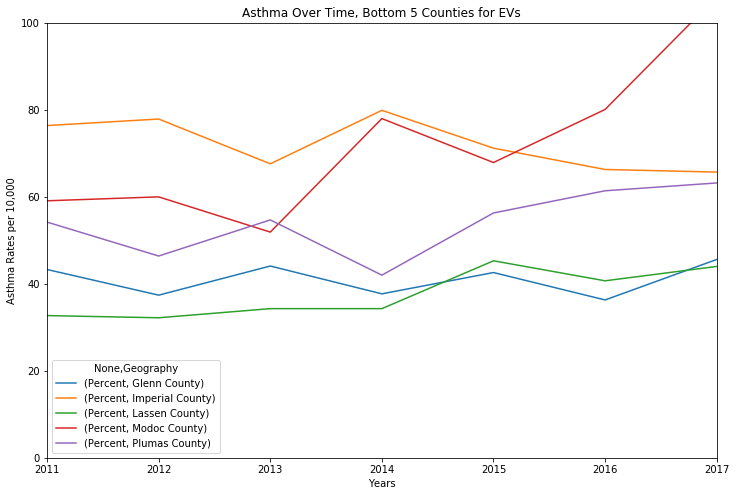

In [23]:
pivot_low.plot(kind='line', figsize=(12,8))
plt.ylim(0,100)
plt.title('Asthma Over Time, Bottom 5 Counties for EVs')
plt.xlabel('Years')
plt.ylabel('Asthma Rates per 10,000')

plt.savefig('../output/bottom_5_asthma.png')

plt.show()

In [24]:
final.head()

,COUNTY,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,1,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728
1,3,0.001826,0.001589,0.016284,0.016283,0.001826,0.001589,0.019936,0.019460
2,5,0.001196,0.001195,0.017230,0.017539,0.001196,0.001195,0.019622,0.019928
3,7,0.001501,0.001618,0.022536,0.023527,0.001501,0.001618,0.025537,0.026763
4,9,0.001526,0.001507,0.017629,0.018075,0.001526,0.001507,0.020682,0.021089


The r value is -0.3944
The p value is 0.0026
-281.0156127237393


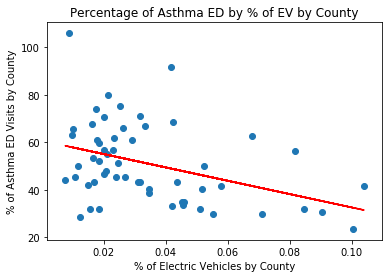

In [113]:
#linear regression
ed_2017 = reduced[reduced['Year'] == 2017]
adj_low_emiss = final[['% Adj Low Emission','COUNTY']]

ed_adj = pd.merge(ed_2017, adj_low_emiss,
                 how = 'left', on = 'COUNTY')
ed_adj_no_na = ed_adj.dropna()
x = ed_adj_no_na['% Adj Low Emission']
y = ed_adj_no_na['Percent']

slope,intercept, r_value, p_value, std_err = st.linregress(x,y)
regress_values = x*slope + intercept
plt.plot(x,regress_values,'r-')
pearson = st.pearsonr(x,y)
plt.scatter(x,y)
plt.title('Percentage of Asthma ED by % of EV by County')
plt.xlabel('% of Electric Vehicles by County')
plt.ylabel('% of Asthma ED Visits by County')

r = round(r_value,4)
p = round(p_value,4)
print('The r value is ' + str(r))
print('The p value is ' + str(p))
print(str(slope))
plt.savefig('../output/asthma_regression.png')


In [26]:
import pandas as pd
geocodes = '../data/geocodes.csv'
df = pd.read_csv(geocodes)
df.head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
0,10,0,0,0,0,0,United States
1,40,1,0,0,0,0,Alabama
2,50,1,1,0,0,0,Autauga County
3,50,1,3,0,0,0,Baldwin County
4,50,1,5,0,0,0,Barbour County


In [27]:
#identifying california state code
ca_code = df.loc[df['Area Name (including legal/statistical area description)'] == 'California']

#state code equals 6
#pulling only california state/county code
fips = df[['State Code (FIPS)','County Code (FIPS)','Area Name (including legal/statistical area description)']].loc[df['State Code (FIPS)']==6].rename(columns = {'Area Name (including legal/statistical area description)': 'County'})
fips.head()

,State Code (FIPS),County Code (FIPS),County
1393,6,0,California
1394,6,1,Alameda County
1395,6,3,Alpine County
1396,6,5,Amador County
1397,6,7,Butte County


In [28]:
#importing air pollution data
pollution = '../data/AIR_DATA.csv'
df2 = pd.read_csv(pollution)
df2.head()

#reducing to only California
ca_poll = df2.loc[df2['State']== 'California']


ca_poll['County'] = ca_poll['County'] + str(' County')
ca_poll

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
50,California,Alameda County,2018,365,175,173,5,10,2,0,223,76,51,0,10,72,0,283,0
51,California,Amador County,2018,364,288,70,6,0,0,0,129,71,40,0,0,364,0,0,0
52,California,Butte County,2018,365,152,173,22,11,3,4,445,104,54,0,0,203,0,161,1
53,California,Calaveras County,2018,364,148,196,14,6,0,0,157,87,53,0,0,141,0,223,0
54,California,Colusa County,2018,365,245,92,10,17,1,0,274,81,42,0,0,176,0,155,34
55,California,Contra Costa County,2018,365,203,144,7,9,2,0,245,71,48,0,1,107,1,256,0
56,California,Del Norte County,2018,180,162,18,0,0,0,0,77,52,25,0,0,0,0,180,0
57,California,El Dorado County,2018,365,222,106,27,9,1,0,203,101,45,0,0,353,0,3,9
58,California,Fresno County,2018,365,84,183,79,19,0,0,185,133,74,0,3,231,0,121,10
59,California,Glenn County,2018,363,275,72,9,6,1,0,230,69,36,0,0,154,0,136,73


In [29]:
print(len(ca_poll))
print(len(fips))

53
541


In [30]:
#merging by county with air pollution data
ca_fips = pd.merge(ca_poll, fips,
                  how = 'left', on = 'County')
print(len(ca_fips))
ca_fips

53


,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,State Code (FIPS),County Code (FIPS)
0,California,Alameda County,2018,365,175,173,5,10,2,0,...,76,51,0,10,72,0,283,0,6,1
1,California,Amador County,2018,364,288,70,6,0,0,0,...,71,40,0,0,364,0,0,0,6,5
2,California,Butte County,2018,365,152,173,22,11,3,4,...,104,54,0,0,203,0,161,1,6,7
3,California,Calaveras County,2018,364,148,196,14,6,0,0,...,87,53,0,0,141,0,223,0,6,9
4,California,Colusa County,2018,365,245,92,10,17,1,0,...,81,42,0,0,176,0,155,34,6,11
5,California,Contra Costa County,2018,365,203,144,7,9,2,0,...,71,48,0,1,107,1,256,0,6,13
6,California,Del Norte County,2018,180,162,18,0,0,0,0,...,52,25,0,0,0,0,180,0,6,15
7,California,El Dorado County,2018,365,222,106,27,9,1,0,...,101,45,0,0,353,0,3,9,6,17
8,California,Fresno County,2018,365,84,183,79,19,0,0,...,133,74,0,3,231,0,121,10,6,19
9,California,Glenn County,2018,363,275,72,9,6,1,0,...,69,36,0,0,154,0,136,73,6,21


# Scott's Code

In [106]:
#exporting to CSV
ca_fips.to_csv('../data/air_pollution_california_only.csv')

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [108]:
#Access and read ca_demo.csv
ca_demo_file = "../data/ca_demo.csv"

#Read ca.demo.csv and display data columns
ca_demo_data = pd.read_csv(ca_demo_file)
pd.options.display.max_columns = None
display(ca_demo_data)

#Read ca_med_hh_inc.csv 
ca_inc_file = "..\data\ca_med_hh_inc.csv"

#Read the EV sales data total US
ev_sales_us = "..\data\ev_sales_data.csv"

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,6,1,California,Alameda County,1,0,1510271,740573,769698,400793,398814,93553,105762,9038,8697,193411,210284,7200,7563,36578,38578,431433,430796,104982,118494,18125,18673,215131,232675,11680,12393,567300,603082,256303,261199,86764,98561,1985,2263,188629,205423,6042,6356,27577,29280,279055,285124,95313,108165,6859,7997,206870,224197,9520,10068,173273,166616,144490,137615,6789,7201,7053,6434,4782,4861,1158,1207,9001,9298,152378,145672,9669,10329,11266,10676,8261,8478,2160,2325
1,50,6,1,California,Alameda County,1,1,97652,50259,47393,24349,22770,6082,6024,813,677,12901,12146,541,552,5573,5224,29177,27285,7987,7780,1679,1514,16602,15641,1090,1091,33173,31340,10962,10175,5188,5177,132,133,12346,11575,387,416,4158,3864,14558,13517,6557,6432,509,506,15378,14396,773,778,17086,16053,13387,12595,894,847,681,544,555,571,154,136,1415,1360,14619,13768,1430,1348,1170,1008,1224,1245,317,313
2,50,6,1,California,Alameda County,1,2,94546,48145,46401,23285,22400,6309,6079,662,628,12724,12366,533,472,4632,4456,27284,26297,7870,7582,1478,1403,15709,15188,987,913,32719,31402,10933,10358,5565,5341,107,99,12189,11890,413,365,3512,3349,13948,13282,6746,6433,482,472,14660,14236,745,664,15426,14999,12352,12042,744,738,555,529,535,476,120,107,1120,1107,13336,13015,1124,1149,996,931,1049,952,242,249
3,50,6,1,California,Alameda County,1,3,91070,46403,44667,22735,21919,6638,6468,630,626,11851,11129,569,590,3980,3935,26163,25283,8022,7891,1415,1396,14283,13505,1007,998,31996,30758,10981,10666,5986,5809,117,103,11435,10721,472,477,3005,2982,13573,13208,7065,6895,493,471,13439,12694,793,787,14407,13909,11754,11253,652,659,513,523,416,408,97,113,975,953,12590,12075,957,996,922,925,844,811,214,211
4,50,6,1,California,Alameda County,1,4,100394,51445,48949,25363,24069,7793,7504,721,704,13185,12332,629,627,3754,3713,28577,27251,9005,8749,1465,1461,15503,14556,1053,1083,36787,34846,13372,12583,7107,6914,141,143,12750,11918,526,515,2891,2773,15825,14934,8054,7833,520,509,14703,13790,835,854,14658,14103,11991,11486,686,590,580,561,435,414,103,112,863,940,12752,12317,951,916,945,952,800,766,218,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,11,14,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1533,1568,77,79,94,102,108,105,9,10,1526,1576,1274,1324,64,67,45,52,92,89,5,4,46,40,1317,1357,71,75,75,81,103,96,8,8,240,238,210,202,4,3,15,17,4,6,0,1,7,9,216,211,6,4,19,21,5,9,1,2
12118,50,6,115,California,Yuba County,11,15,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1085,1251,44,50,59,75,64,78,7,10,1056,1226,906,1042,41,39,19,29,55,63,2,3,33,50,939,1088,43,44,41,64,62,75,4,8,165,181,141,159,0,4,16,9,0,3,3,2,5,4,146,163,1,6,18,11,2,3,3,2
12119,50,6,115,California,Yuba County,11,16,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,760,747,26,28,41,49,36,57,3,5,720,760,639,643,18,22,20,24,31,51,2,3,10,17,647,657,20,25,28,36,34,55,3,5,126,100,105,82,4,1,7,8,2,1,0

In [109]:
#Create a dataframe that includes rows with 2018 pop estimates (YEAR = 11)

# filtered_df = df.loc[df['Symbol'] == 'A99']

ca_2018_df = ca_demo_data.loc[ca_demo_data['YEAR'] == 11]
ca_2018_df

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
190,50,6,1,California,Alameda County,11,0,1666753,820045,846708,417023,411943,88566,97364,9180,8793,253975,275235,7569,8301,43732,45072,454152,449820,102861,112699,18757,19455,280536,301800,13027,14136,631373,662340,259188,258782,81542,89976,1973,2208,248635,269804,6417,7065,33618,34505,287360,287343,92452,101696,6192,7317,271391,292422,10689,11668,188672,184368,157835,153161,7024,7388,7207,6585,5340,5431,1152,1236,10114,10567,166792,162477,10409,11003,12565,12138,9145,9378,2338,2468
191,50,6,1,California,Alameda County,11,1,96716,49506,47210,23976,22753,5016,4875,475,528,14242,13327,516,535,5281,5192,28706,27392,6992,6891,1080,1097,17823,16790,951,989,34230,32749,11355,10929,4477,4380,113,114,13768,12883,406,434,4111,4009,15044,14512,5943,5861,305,294,16777,15783,699,738,15276,14461,12621,11824,539,495,362,414,474,444,110,101,1170,1183,13662,12880,1049,1030,775,803,1046,1007,252,251
192,50,6,1,California,Alameda County,11,2,95425,48711,46714,22773,21852,5073,4843,513,540,14905,14233,462,464,4985,4782,27236,26150,6953,6706,1121,1116,18228,17361,921,875,33658,32041,10402,9788,4523,4328,103,147,14477,13804,370,360,3783,3614,13796,13036,5888,5679,279,322,17225,16388,680,627,15053,14673,12371,12064,550,515,410,393,428,429,92,104,1202,1168,13440,13114,1065,1027,842,794,1003,973,241,248
193,50,6,1,California,Alameda County,11,3,95370,48947,46423,23178,21725,5197,4991,744,612,14346,14023,540,515,4942,4557,27584,25791,7112,6796,1391,1215,17498,16882,985,926,32925,31273,10315,9576,4511,4258,147,112,13833,13531,407,398,3712,3398,13624,12595,5944,5600,325,278,16416,15866,703,660,16022,15150,12863,12149,686,733,597,500,513,492,133,117,1230,1159,13960,13196,1168,1196,1066,937,1082,1016,282,266
194,50,6,1,California,Alameda County,11,4,93570,47278,46292,23006,22384,5475,5252,645,605,13528,13639,477,459,4147,3953,26736,25926,7127,6861,1248,1232,16013,15914,820,810,32652,31907,11044,10581,4821,4620,103,94,13080,13214,373,384,3231,3014,13945,13279,6146,5902,299,306,15181,15105,605,628,14626,14385,11962,11803,654,632,542,511,448,425,104,75,916,939,12791,12647,981,959,949,926,832,809,215,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,11,14,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1533,1568,77,79,94,102,108,105,9,10,1526,1576,1274,1324,64,67,45,52,92,89,5,4,46,40,1317,1357,71,75,75,81,103,96,8,8,240,238,210,202,4,3,15,17,4,6,0,1,7,9,216,211,6,4,19,21,5,9,1,2
12118,50,6,115,California,Yuba County,11,15,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1085,1251,44,50,59,75,64,78,7,10,1056,1226,906,1042,41,39,19,29,55,63,2,3,33,50,939,1088,43,44,41,64,62,75,4,8,165,181,141,159,0,4,16,9,0,3,3,2,5,4,146,163,1,6,18,11,2,3,3,2
12119,50,6,115,California,Yuba County,11,16,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,760,747,26,28,41,49,36,57,3,5,720,760,639,643,18,22,20,24,31,51,2,3,10,17,647,657,20,25,28,36,34,55,3,5,126,100,105,82

In [110]:
# Under AGEGRP convert 1-4 = Age <20 yrs, 5-6 = Age 20-29 yrs, 7-8 = Age 30-39 yrs, 9-10 = Age 40-49 yrs, 
# 11-12 = Age 50-59 yrs, 13-14 = Age 60-69 yrs, 151-8 = Age 70+ yrs

ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([0], 'All Ages'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([1, 2, 3, 4], 'Age <20 yrs'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([5, 6], 'Age 20-29 yrs'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([7, 8], 'Age 30-39 yrs'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([9, 10], 'Age 40-49 yrs'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([11, 12], 'Age 50-59 yrs'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([13, 14], 'Age 60-69 yrs'))
ca_2018_df[['AGEGRP']] = ca_2018_df[['AGEGRP']].replace(dict.fromkeys([15, 16, 17, 18], 'Age 70+ yrs'))

ca_2018_df

C:\Users\adfil\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
190,50,6,1,California,Alameda County,11,All Ages,1666753,820045,846708,417023,411943,88566,97364,9180,8793,253975,275235,7569,8301,43732,45072,454152,449820,102861,112699,18757,19455,280536,301800,13027,14136,631373,662340,259188,258782,81542,89976,1973,2208,248635,269804,6417,7065,33618,34505,287360,287343,92452,101696,6192,7317,271391,292422,10689,11668,188672,184368,157835,153161,7024,7388,7207,6585,5340,5431,1152,1236,10114,10567,166792,162477,10409,11003,12565,12138,9145,9378,2338,2468
191,50,6,1,California,Alameda County,11,Age <20 yrs,96716,49506,47210,23976,22753,5016,4875,475,528,14242,13327,516,535,5281,5192,28706,27392,6992,6891,1080,1097,17823,16790,951,989,34230,32749,11355,10929,4477,4380,113,114,13768,12883,406,434,4111,4009,15044,14512,5943,5861,305,294,16777,15783,699,738,15276,14461,12621,11824,539,495,362,414,474,444,110,101,1170,1183,13662,12880,1049,1030,775,803,1046,1007,252,251
192,50,6,1,California,Alameda County,11,Age <20 yrs,95425,48711,46714,22773,21852,5073,4843,513,540,14905,14233,462,464,4985,4782,27236,26150,6953,6706,1121,1116,18228,17361,921,875,33658,32041,10402,9788,4523,4328,103,147,14477,13804,370,360,3783,3614,13796,13036,5888,5679,279,322,17225,16388,680,627,15053,14673,12371,12064,550,515,410,393,428,429,92,104,1202,1168,13440,13114,1065,1027,842,794,1003,973,241,248
193,50,6,1,California,Alameda County,11,Age <20 yrs,95370,48947,46423,23178,21725,5197,4991,744,612,14346,14023,540,515,4942,4557,27584,25791,7112,6796,1391,1215,17498,16882,985,926,32925,31273,10315,9576,4511,4258,147,112,13833,13531,407,398,3712,3398,13624,12595,5944,5600,325,278,16416,15866,703,660,16022,15150,12863,12149,686,733,597,500,513,492,133,117,1230,1159,13960,13196,1168,1196,1066,937,1082,1016,282,266
194,50,6,1,California,Alameda County,11,Age <20 yrs,93570,47278,46292,23006,22384,5475,5252,645,605,13528,13639,477,459,4147,3953,26736,25926,7127,6861,1248,1232,16013,15914,820,810,32652,31907,11044,10581,4821,4620,103,94,13080,13214,373,384,3231,3014,13945,13279,6146,5902,299,306,15181,15105,605,628,14626,14385,11962,11803,654,632,542,511,448,425,104,75,916,939,12791,12647,981,959,949,926,832,809,215,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,11,Age 60-69 yrs,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1533,1568,77,79,94,102,108,105,9,10,1526,1576,1274,1324,64,67,45,52,92,89,5,4,46,40,1317,1357,71,75,75,81,103,96,8,8,240,238,210,202,4,3,15,17,4,6,0,1,7,9,216,211,6,4,19,21,5,9,1,2
12118,50,6,115,California,Yuba County,11,Age 70+ yrs,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1085,1251,44,50,59,75,64,78,7,10,1056,1226,906,1042,41,39,19,29,55,63,2,3,33,50,939,1088,43,44,41,64,62,75,4,8,165,181,141,159,0,4,16,9,0,3,3,2,5,4,146,163,1,6,18,11,2,3,3,2
12119,50,6,115,California,Yuba County,11,Age 70+ yrs,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,760,747,26,28,41,49,36,57,3,5,720,760,639,

In [111]:
#Under YEAR convert 11 = 2018 & remove last column "Year" which was all NaN's
ca_2018_year = ca_2018_df.replace(to_replace = 11, 
                                  value ='2018')
ca_2018_year

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
190,50,6,1,California,Alameda County,2018,All Ages,1666753,820045,846708,417023,411943,88566,97364,9180,8793,253975,275235,7569,8301,43732,45072,454152,449820,102861,112699,18757,19455,280536,301800,13027,14136,631373,662340,259188,258782,81542,89976,1973,2208,248635,269804,6417,7065,33618,34505,287360,287343,92452,101696,6192,7317,271391,292422,10689,11668,188672,184368,157835,153161,7024,7388,7207,6585,5340,5431,1152,1236,10114,10567,166792,162477,10409,11003,12565,12138,9145,9378,2338,2468
191,50,6,1,California,Alameda County,2018,Age <20 yrs,96716,49506,47210,23976,22753,5016,4875,475,528,14242,13327,516,535,5281,5192,28706,27392,6992,6891,1080,1097,17823,16790,951,989,34230,32749,11355,10929,4477,4380,113,114,13768,12883,406,434,4111,4009,15044,14512,5943,5861,305,294,16777,15783,699,738,15276,14461,12621,11824,539,495,362,414,474,444,110,101,1170,1183,13662,12880,1049,1030,775,803,1046,1007,252,251
192,50,6,1,California,Alameda County,2018,Age <20 yrs,95425,48711,46714,22773,21852,5073,4843,513,540,14905,14233,462,464,4985,4782,27236,26150,6953,6706,1121,1116,18228,17361,921,875,33658,32041,10402,9788,4523,4328,103,147,14477,13804,370,360,3783,3614,13796,13036,5888,5679,279,322,17225,16388,680,627,15053,14673,12371,12064,550,515,410,393,428,429,92,104,1202,1168,13440,13114,1065,1027,842,794,1003,973,241,248
193,50,6,1,California,Alameda County,2018,Age <20 yrs,95370,48947,46423,23178,21725,5197,4991,744,612,14346,14023,540,515,4942,4557,27584,25791,7112,6796,1391,1215,17498,16882,985,926,32925,31273,10315,9576,4511,4258,147,112,13833,13531,407,398,3712,3398,13624,12595,5944,5600,325,278,16416,15866,703,660,16022,15150,12863,12149,686,733,597,500,513,492,133,117,1230,1159,13960,13196,1168,1196,1066,937,1082,1016,282,266
194,50,6,1,California,Alameda County,2018,Age <20 yrs,93570,47278,46292,23006,22384,5475,5252,645,605,13528,13639,477,459,4147,3953,26736,25926,7127,6861,1248,1232,16013,15914,820,810,32652,31907,11044,10581,4821,4620,103,94,13080,13214,373,384,3231,3014,13945,13279,6146,5902,299,306,15181,15105,605,628,14626,14385,11962,11803,654,632,542,511,448,425,104,75,916,939,12791,12647,981,959,949,926,832,809,215,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,2018,Age 60-69 yrs,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1533,1568,77,79,94,102,108,105,9,10,1526,1576,1274,1324,64,67,45,52,92,89,5,4,46,40,1317,1357,71,75,75,81,103,96,8,8,240,238,210,202,4,3,15,17,4,6,0,1,7,9,216,211,6,4,19,21,5,9,1,2
12118,50,6,115,California,Yuba County,2018,Age 70+ yrs,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1085,1251,44,50,59,75,64,78,7,10,1056,1226,906,1042,41,39,19,29,55,63,2,3,33,50,939,1088,43,44,41,64,62,75,4,8,165,181,141,159,0,4,16,9,0,3,3,2,5,4,146,163,1,6,18,2018,2,3,3,2
12119,50,6,115,California,Yuba County,2018,Age 70+ yrs,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,760,747,26,28,41,49,36,5

In [112]:
#Remove the unneccesary ethnicity columns and create new dataframe.

ca_2018_new = ca_2018_year.loc[:, ('SUMLEV', 'STATE','COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'AGEGRP', 'TOT_POP',
                                   'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
                                   'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE',
                                  'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE')]
ca_2018_new

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE
190,50,6,1,California,Alameda County,2018,All Ages,1666753,820045,846708,417023,411943,88566,97364,9180,8793,253975,275235,7569,8301,43732,45072,631373,662340,188672,184368
191,50,6,1,California,Alameda County,2018,Age <20 yrs,96716,49506,47210,23976,22753,5016,4875,475,528,14242,13327,516,535,5281,5192,34230,32749,15276,14461
192,50,6,1,California,Alameda County,2018,Age <20 yrs,95425,48711,46714,22773,21852,5073,4843,513,540,14905,14233,462,464,4985,4782,33658,32041,15053,14673
193,50,6,1,California,Alameda County,2018,Age <20 yrs,95370,48947,46423,23178,21725,5197,4991,744,612,14346,14023,540,515,4942,4557,32925,31273,16022,15150
194,50,6,1,California,Alameda County,2018,Age <20 yrs,93570,47278,46292,23006,22384,5475,5252,645,605,13528,13639,477,459,4147,3953,32652,31907,14626,14385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,2018,Age 60-69 yrs,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1526,1576,240,238
12118,50,6,115,California,Yuba County,2018,Age 70+ yrs,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1056,1226,165,181
12119,50,6,115,California,Yuba County,2018,Age 70+ yrs,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,720,760,126,100
12120,50,6,115,California,Yuba County,2018,Age 70+ yrs,1086,470,616,408,540,10,17,15,2018,24,35,1,2,12,2018,409,531,61,85


In [113]:
#Check dataframe data types. Number values that need to be combined atre currently strings(objects)
ca_2018_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 190 to 12121
Data columns (total 26 columns):
SUMLEV        1102 non-null int64
STATE         1102 non-null int64
COUNTY        1102 non-null object
STNAME        1102 non-null object
CTYNAME       1102 non-null object
YEAR          1102 non-null object
AGEGRP        1102 non-null object
TOT_POP       1102 non-null int64
TOT_MALE      1102 non-null int64
TOT_FEMALE    1102 non-null int64
WA_MALE       1102 non-null int64
WA_FEMALE     1102 non-null int64
BA_MALE       1102 non-null object
BA_FEMALE     1102 non-null object
IA_MALE       1102 non-null object
IA_FEMALE     1102 non-null object
AA_MALE       1102 non-null object
AA_FEMALE     1102 non-null object
NA_MALE       1102 non-null object
NA_FEMALE     1102 non-null object
TOM_MALE      1102 non-null object
TOM_FEMALE    1102 non-null object
NH_MALE       1102 non-null int64
NH_FEMALE     1102 non-null object
H_MALE        1102 non-null object
H_FEMALE      1102 non-

In [114]:
# Convert all population numbers from being strings to integers
# Convert data under "SumLev and "STATE from int to strings

ca_2018_new[['BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE',
             'TOM_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE']] = ca_2018_new[['BA_MALE', 'BA_FEMALE', 'IA_MALE', 
                                                                                         'IA_FEMALE', 'AA_MALE', 'AA_FEMALE',
                                                                                         'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 
                                                                                         'TOM_FEMALE', 'NH_MALE', 'NH_FEMALE', 
                                                                                         'H_MALE', 'H_FEMALE']].astype(int)
ca_2018_new[["SUMLEV", "STATE"]] = ca_2018_new[["SUMLEV", "STATE"]].astype(str)
ca_2018_new

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE
190,50,6,1,California,Alameda County,2018,All Ages,1666753,820045,846708,417023,411943,88566,97364,9180,8793,253975,275235,7569,8301,43732,45072,631373,662340,188672,184368
191,50,6,1,California,Alameda County,2018,Age <20 yrs,96716,49506,47210,23976,22753,5016,4875,475,528,14242,13327,516,535,5281,5192,34230,32749,15276,14461
192,50,6,1,California,Alameda County,2018,Age <20 yrs,95425,48711,46714,22773,21852,5073,4843,513,540,14905,14233,462,464,4985,4782,33658,32041,15053,14673
193,50,6,1,California,Alameda County,2018,Age <20 yrs,95370,48947,46423,23178,21725,5197,4991,744,612,14346,14023,540,515,4942,4557,32925,31273,16022,15150
194,50,6,1,California,Alameda County,2018,Age <20 yrs,93570,47278,46292,23006,22384,5475,5252,645,605,13528,13639,477,459,4147,3953,32652,31907,14626,14385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,2018,Age 60-69 yrs,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1526,1576,240,238
12118,50,6,115,California,Yuba County,2018,Age 70+ yrs,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1056,1226,165,181
12119,50,6,115,California,Yuba County,2018,Age 70+ yrs,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,720,760,126,100
12120,50,6,115,California,Yuba County,2018,Age 70+ yrs,1086,470,616,408,540,10,17,15,2018,24,35,1,2,12,2018,409,531,61,85


In [115]:
ca_2018_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 190 to 12121
Data columns (total 26 columns):
SUMLEV        1102 non-null object
STATE         1102 non-null object
COUNTY        1102 non-null object
STNAME        1102 non-null object
CTYNAME       1102 non-null object
YEAR          1102 non-null object
AGEGRP        1102 non-null object
TOT_POP       1102 non-null int64
TOT_MALE      1102 non-null int64
TOT_FEMALE    1102 non-null int64
WA_MALE       1102 non-null int64
WA_FEMALE     1102 non-null int64
BA_MALE       1102 non-null int32
BA_FEMALE     1102 non-null int32
IA_MALE       1102 non-null int32
IA_FEMALE     1102 non-null int32
AA_MALE       1102 non-null int32
AA_FEMALE     1102 non-null int32
NA_MALE       1102 non-null int32
NA_FEMALE     1102 non-null int32
TOM_MALE      1102 non-null int32
TOM_FEMALE    1102 non-null int32
NH_MALE       1102 non-null int32
NH_FEMALE     1102 non-null int32
H_MALE        1102 non-null int32
H_FEMALE      1102 non-null int32

In [116]:
# Sum White ("WA_MAlE" + "WA-FEMALE"), BLACK ("BA_MALE" + "BA_FEMALE"), etc,
#ethnic population numbers and create new ethnic pop columns ('white_tot', black_tot, asian_tot, etc.) 

ca_2018_new['white_tot'] = ca_2018_new.loc[:, 'WA_MALE':'WA_FEMALE'].sum(1)
ca_2018_new['black_tot'] = ca_2018_new.loc[:, 'BA_MALE':'BA_FEMALE'].sum(1)
ca_2018_new['asian_tot'] = ca_2018_new.loc[:, 'AA_MALE':'AA_FEMALE'].sum(1) 
ca_2018_new['wht/blk/asn_tot'] = ca_2018_new.loc[:, 'white_tot':'asian_tot'].sum(1)
ca_2018_new['nonhisp_tot'] = ca_2018_new.loc[:, 'NH_MALE':'NH_FEMALE'].sum(1)
ca_2018_new['hisp_tot'] = ca_2018_new.loc[:, 'H_MALE':'H_FEMALE'].sum(1)
ca_2018_new['other_tot'] = ca_2018_new['TOT_POP'] - ca_2018_new['wht/blk/asn_tot']
ca_2018_new

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,white_tot,black_tot,asian_tot,wht/blk/asn_tot,nonhisp_tot,hisp_tot,other_tot
190,50,6,1,California,Alameda County,2018,All Ages,1666753,820045,846708,417023,411943,88566,97364,9180,8793,253975,275235,7569,8301,43732,45072,631373,662340,188672,184368,828966,185930,529210,1544106,1293713,373040,122647
191,50,6,1,California,Alameda County,2018,Age <20 yrs,96716,49506,47210,23976,22753,5016,4875,475,528,14242,13327,516,535,5281,5192,34230,32749,15276,14461,46729,9891,27569,84189,66979,29737,12527
192,50,6,1,California,Alameda County,2018,Age <20 yrs,95425,48711,46714,22773,21852,5073,4843,513,540,14905,14233,462,464,4985,4782,33658,32041,15053,14673,44625,9916,29138,83679,65699,29726,11746
193,50,6,1,California,Alameda County,2018,Age <20 yrs,95370,48947,46423,23178,21725,5197,4991,744,612,14346,14023,540,515,4942,4557,32925,31273,16022,15150,44903,10188,28369,83460,64198,31172,11910
194,50,6,1,California,Alameda County,2018,Age <20 yrs,93570,47278,46292,23006,22384,5475,5252,645,605,13528,13639,477,459,4147,3953,32652,31907,14626,14385,45390,10727,27167,83284,64559,29011,10286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,50,6,115,California,Yuba County,2018,Age 60-69 yrs,3580,1766,1814,1484,1526,68,70,60,69,96,95,5,5,53,49,1526,1576,240,238,3010,138,191,3339,3102,478,241
12118,50,6,115,California,Yuba County,2018,Age 70+ yrs,2628,1221,1407,1047,1201,41,43,35,38,55,66,5,5,38,54,1056,1226,165,181,2248,84,121,2453,2282,346,175
12119,50,6,115,California,Yuba County,2018,Age 70+ yrs,1706,846,860,744,725,22,23,27,32,33,52,2,3,18,25,720,760,126,100,1469,45,85,1599,1480,226,107
12120,50,6,115,California,Yuba County,2018,Age 70+ yrs,1086,470,616,408,540,10,17,15,2018,24,35,1,2,12,2018,409,531,61,85,948,27,59,1034,940,146,52


In [117]:
#Group data by 'County' & AGEGRP' to aggregate newly defined age groups.
grpby_ca_2018 = ca_2018_new.groupby(['CTYNAME', 'AGEGRP'])
grpby_ca_2018.sum()


TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  \
CTYNAME        AGEGRP                                                  
Alameda County Age 20-29 yrs   236999    118947      118052    58763   
               Age 30-39 yrs   275770    138331      137439    68568   
               Age 40-49 yrs   232199    115521      116678    57779   
               Age 50-59 yrs   214392    105571      108821    57721   
               Age 60-69 yrs   173977     82329       91648    44795   
...                               ...       ...         ...      ...   
Yuba County    Age 50-59 yrs     8771      4429        4342     3664   
               Age 60-69 yrs     7832      3830        4002     3227   
               Age 70+ yrs       6375      2941        3434     2560   
               Age <20 yrs      23414     12095       11319     8990   
               All Ages         78041     39503       38538    30932   

                              WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  \
CTYNAME        AGEGRP                                                  
Alameda County Age 20-29 yrs      56349    13800      13757     1589   
               Age 30-39 yrs      62839    13407      14173     1737   
               Age 40-49 yrs      54216    11701      13261     1359   
               Age 50-59 yrs      54677    12159      13619     1088   
               Age 60-69 yrs      47024     9600      11902      650   
...                                 ...      ...        ...      ...   
Yuba County    Age 50-59 yrs       3595      214        162      105   
               Age 60-69 yrs       3347      158        138      116   
               Age 70+ yrs         2945       81         97       83   
               Age <20 yrs         8433      544        481      306   
               All Ages           30169     1875       1545     1049   

                              IA_FEMALE  AA_MALE  AA_FEMALE  NA_MALE  \
CTYNAME        AGEGRP                                                  
Alameda County Age 20-29 yrs       1405    35968      37377     1156   
               Age 30-39 yrs       1540    47124      50762     1425   
               Age 40-49 yrs       1281    39673      42157      958   
               Age 50-59 yrs       1115    30443      34724      960   
               Age 60-69 yrs        665    24510      29053      648   
...                                 ...      ...        ...      ...   
Yuba County    Age 50-59 yrs        128      251        267       17   
               Age 60-69 yrs        159      193        209       18   
               Age 70+ yrs         2103      133        190       10   
               Age <20 yrs          359      930        834       74   
               All Ages            1231     2888       2976      201   

                              NA_FEMALE  TOM_MALE  TOM_FEMALE  NH_MALE  \
CTYNAME        AGEGRP                                                    
Alameda County Age 20-29 yrs       1335      7671        7829    87605   
               Age 30-39 yrs       1447      6070        6678   106416   
               Age 40-49 yrs       1142      4051        4621    88591   
               Age 50-59 yrs       1127      3200        3559    85586   
               Age 60-69 yrs        768      2126        2236    71640   
...                                 ...       ...         ...      ...   
Yuba County    Age 50-59 yrs       2028       178         169     3513   
               Age 60-69 yrs         22       118         127     3238   
               Age 70+ yrs           12        74        2101     2518   
               Age <20 yrs           58      1251        1154     7473   
               All Ages             195      2558        2422    28054   

                              NH_FEMALE  H_MALE  H_FEMALE  white_tot  \
CTYNAME        AGEGRP                                                  
Alameda County Age 20-29 yrs      87284   31342     30768     115112   
               Age 30-39 yrs     108374 

In [118]:
#Create new Data Frame only including aggregated ethnicity group data columns
grpby_ca_rev = grpby_ca_2018[['TOT_POP', 'white_tot', 'black_tot', 'asian_tot', 'other_tot']]
grpD=grpby_ca_rev.sum().reset_index()
grpD.head()

,CTYNAME,AGEGRP,TOT_POP,white_tot,black_tot,asian_tot,other_tot
0,Alameda County,Age 20-29 yrs,236999,115112,27557,73345,20985
1,Alameda County,Age 30-39 yrs,275770,131407,27580,97886,18897
2,Alameda County,Age 40-49 yrs,232199,111995,24962,81830,13412
3,Alameda County,Age 50-59 yrs,214392,112398,25778,65167,11049
4,Alameda County,Age 60-69 yrs,173977,91819,21502,53563,7093


In [119]:
ctMax=grpD.loc[(grpD.CTYNAME=='San Francisco County')\
         |(grpD.CTYNAME=='Marin County')\
         |(grpD.CTYNAME=='Santa Clara County')\
         |(grpD.CTYNAME=='San Mateo County')\
         |(grpD.CTYNAME=='Alameda County')]
        
ctMax=ctMax.loc[ctMax.AGEGRP=="All Ages"]
ctMax

,CTYNAME,AGEGRP,TOT_POP,white_tot,black_tot,asian_tot,other_tot
7,Alameda County,All Ages,1666753,828966,185930,529210,122647
167,Marin County,All Ages,259666,221914,7321,16847,13584
303,San Francisco County,All Ages,883305,467444,49184,317204,49473
327,San Mateo County,All Ages,769545,462008,21123,231957,54457
343,Santa Clara County,All Ages,1937570,1028134,54961,742295,112180


In [120]:
AC_ethnic = ["", "", "", ""] 
pops = [828966, 185930, 529210, 122647]
colors = ["dodgerblue", "aqua", "grey", "white"]

plt.title("Alameda County")
plt.pie(pops, labels=AC_ethnic, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=90, 
       wedgeprops={"edgecolor":"black"})
plt.axis("equal")
plt.savefig('../output/alameda_pie.png')
plt.show() 


In [121]:
MC_ethnic = ["", "", "", ""] 
pops = [221914, 7321, 16847, 13584]
colors = ["dodgerblue", "cyan", "grey", "white"]

plt.title("Marin County")
plt.pie(pops, labels=MC_ethnic, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=90, 
       wedgeprops={"edgecolor":"black"})
plt.axis("equal")
plt.savefig('../output/marin_pie.png')
plt.show() 


In [122]:
SFC_ethnic = ["", "", "", ""] 
pops = [467444, 49184, 317204, 49473]
colors = ["dodgerblue", "cyan", "grey", "white"]

plt.title("San Francisco County")
plt.pie(pops, labels=SFC_ethnic, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=90, 
       wedgeprops={"edgecolor":"black"})
plt.axis("equal")
plt.savefig('../output/sanfran_pie.png')
plt.show() 


In [123]:
SMC_ethnic = ["", "", "", ""] 
pops = [462008, 21123, 231957, 54457]
colors = ["dodgerblue", "cyan", "grey", "white"]

plt.title("San Mateo County")
plt.pie(pops, labels=SMC_ethnic, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=90, 
       wedgeprops={"edgecolor":"black"})
plt.axis("equal")
plt.savefig('../output/sanmat_pie.png')
plt.show() 


In [124]:
SCC_ethnic = ["", "", "", ""] 
pops = [1028134, 54961, 742295, 112180]
colors = ["dodgerblue", "cyan", "grey", "white"]

plt.title("Santa Clara County")
plt.pie(pops, labels=SCC_ethnic, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=90, 
       wedgeprops={"edgecolor":"black"})
plt.axis("equal")
plt.savefig('../output/santa_pie.png')
plt.show() 


In [125]:
#Read ca_med_hh_inc.csv and display data columns 
ca_inc_pd = pd.read_csv(ca_inc_file)
ca_inc_pd.head()

,County,State Code (FIPS),County Code (FIPS),Income,Margin Of Error
0,Alameda County,6,1,"$92,574","+/- $1,023"
1,Alpine County,6,3,"$64,688","+/- $12,933"
2,Amador County,6,5,"$61,198","+/- $3,241"
3,Butte County,6,7,"$48,443","+/- $1,477"
4,Calaveras County,6,9,"$58,151","+/- $3,310"


In [126]:
# Remove "Margine of Error" column and create new data frame
ca_inc_rev = ca_inc_pd[['County', 'State Code (FIPS)', 'County Code (FIPS)', 'Income']]
ca_inc_rev.head()

,County,State Code (FIPS),County Code (FIPS),Income
0,Alameda County,6,1,"$92,574"
1,Alpine County,6,3,"$64,688"
2,Amador County,6,5,"$61,198"
3,Butte County,6,7,"$48,443"
4,Calaveras County,6,9,"$58,151"


In [127]:
#Convert data under "Income" file from strings to floats 

ca_inc_rev['Income'] = ca_inc_rev['Income'].str.replace(',', '')
ca_inc_rev['Income'] = ca_inc_rev['Income'].str.replace('$', '')
ca_inc_rev


C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,County,State Code (FIPS),County Code (FIPS),Income
0,Alameda County,6,1,92574
1,Alpine County,6,3,64688
2,Amador County,6,5,61198
3,Butte County,6,7,48443
4,Calaveras County,6,9,58151
5,Colusa County,6,11,56704
6,Contra Costa County,6,13,93712
7,Del Norte County,6,15,45258
8,El Dorado County,6,17,80582
9,Fresno County,6,19,51261


In [128]:
ca_inc_rev['Income'] = ca_inc_rev['Income'].astype('float64')
ca_inc_rev.head()

C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,County,State Code (FIPS),County Code (FIPS),Income
0,Alameda County,6,1,92574.0
1,Alpine County,6,3,64688.0
2,Amador County,6,5,61198.0
3,Butte County,6,7,48443.0
4,Calaveras County,6,9,58151.0


In [129]:
cnty_med = ca_inc_rev['Income'].median()
cnty_med

59157.5

In [130]:
counties = ['San Francisco County', 'Marin County', 'Santa Clara County', 'San Mateo County', 'Alameda County']
ca_inc_rev2 = ca_inc_rev.loc[ca_inc_rev['County'].isin(counties)]
ca_inc_rev2

,County,State Code (FIPS),County Code (FIPS),Income
0,Alameda County,6,1,92574.0
20,Marin County,6,41,110217.0
37,San Francisco County,6,75,104552.0
40,San Mateo County,6,81,113776.0
42,Santa Clara County,6,85,116178.0


In [131]:
cadf = pd.DataFrame({'County':['California Median'],
                    'State Code (FIPS)':[6],
                    'County Code (FIPS)':['NA'],
                    'Income':[59157.5]},
                   index = [4])

cadf

,County,State Code (FIPS),County Code (FIPS),Income
4,California Median,6,NA,59157.5


In [132]:
cadf2 = pd.concat([cadf, ca_inc_rev2])
print(cadf2)

                  County  State Code (FIPS) County Code (FIPS)    Income
4      California Median                  6                 NA   59157.5
0         Alameda County                  6                  1   92574.0
20          Marin County                  6                 41  110217.0
37  San Francisco County                  6                 75  104552.0
40      San Mateo County                  6                 81  113776.0
42    Santa Clara County                  6                 85  116178.0


In [133]:
cadf2['Income'] = cadf2['Income'].astype('float64')
cadf2

,County,State Code (FIPS),County Code (FIPS),Income
4,California Median,6,NA,59157.5
0,Alameda County,6,1,92574.0
20,Marin County,6,41,110217.0
37,San Francisco County,6,75,104552.0
40,San Mateo County,6,81,113776.0
42,Santa Clara County,6,85,116178.0


In [134]:
cadf2.index = ["California", "Alameda County" , "Marin County", "San Francisco County", "San Mateo", "Santa Clara County"]
data_points = cadf2["Income"]
data_points_bar = data_points.plot(kind="bar", color="dodgerblue", title= "Median HH Income - CA County")
data_points_bar.set_xlabel("County")
data_points_bar.set_ylabel("Income")

plt.xticks(rotation=45)
plt.savefig('../output/median_income_pie.png')
plt.show()


In [135]:
ev_sales_pd = pd.read_csv(ev_sales_us)
ev_sales_pd.head()

,Vehicle,Type,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Chevy Volt,PHEV,767+C2:C411,23461.0,23094.0,18805.0,15393.0,24739.0,20349.0,18306.0,4915.0,149062.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Nissan Leaf,EV,9674,9819.0,22610.0,30200.0,17269.0,14006.0,11230.0,14715.0,12365.0,141888.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Smart ED,EV,342,139.0,923.0,2594.0,1387.0,657.0,544.0,1219.0,680.0,8485.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Mitsubishi I EV,EV,76,588.0,1029.0,196.0,115.0,94.0,6.0,0.0,0.0,2104.0,NaN,NaN,NaN,NaN,NaN,NaN
4,BMW Active E,EV,0,673.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,673.0,NaN,NaN,NaN,,NaN,NaN


In [136]:
ev_sales_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 18 columns):
Vehicle        56 non-null object
Type           55 non-null object
2011           56 non-null object
2012           56 non-null float64
2013           56 non-null float64
2014           56 non-null float64
2015           56 non-null float64
2016           56 non-null float64
2017           56 non-null float64
2018           56 non-null float64
2019           56 non-null float64
Total          56 non-null float64
Unnamed: 12    0 non-null float64
Unnamed: 13    0 non-null float64
Unnamed: 14    1 non-null object
Unnamed: 15    1 non-null object
Unnamed: 16    0 non-null float64
Unnamed: 17    0 non-null float64
dtypes: float64(13), object(5)
memory usage: 8.1+ KB


In [137]:
len(ev_sales_pd.index)

57

In [138]:
ev_sales_pd2 = ev_sales_pd.drop(columns=['Total', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 
                                         'Unnamed: 17'])
ev_sales_pd2.head()

,Vehicle,Type,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Chevy Volt,PHEV,767+C2:C411,23461.0,23094.0,18805.0,15393.0,24739.0,20349.0,18306.0,4915.0
1,Nissan Leaf,EV,9674,9819.0,22610.0,30200.0,17269.0,14006.0,11230.0,14715.0,12365.0
2,Smart ED,EV,342,139.0,923.0,2594.0,1387.0,657.0,544.0,1219.0,680.0
3,Mitsubishi I EV,EV,76,588.0,1029.0,196.0,115.0,94.0,6.0,0.0,0.0
4,BMW Active E,EV,0,673.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
ev_grpby = ev_sales_pd2.groupby('Type')
ev_grpby2 = ev_grpby.sum()
ev_grpby2

,2012,2013,2014,2015,2016,2017,2018,2019
Type,,,,,,,,
EV,14587.0,48094.0,63525.0,71064.0,86731.0,104492.0,238823.0,241912.0
PHEV,38584.0,49008.0,55357.0,42959.0,72885.0,91089.0,122492.0,84732.0


In [140]:
ev_grpby2.sum(axis=1) 
inc_sum = ca_inc_rev['Income'].sum()


In [141]:
ev_grpby2.loc['Total']=ev_grpby2.sum()
ev_grpby2=ev_grpby2.reset_index()

In [142]:
ev_grpby3 = ev_grpby2.loc[ev_grpby2.Type=='Total']
ev_grpby3

,Type,2012,2013,2014,2015,2016,2017,2018,2019
2,Total,53171.0,97102.0,118882.0,114023.0,159616.0,195581.0,361315.0,326644.0


In [144]:
year = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
data_points = [17763, 53171, 97102, 118882, 114023, 159616, 195581, 361315, 326644]


index = np.arange(len(year))
plt.bar(index, data_points, color = "dodgerblue")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.xticks(index, year, rotation = 90)
plt.title("YoY U.S. Electric Vehicle Sales")
plt.savefig('../output/YOY_pie.png')
plt.show()


# ETHAN SECTION

In [145]:
# Grab Data
df_energy = pd.read_csv("../data/ENERGY_USAGE_TYPE_COUNTY.csv")
df_energy.head()

,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified
0,Los Angeles County,1877.0,6999.0,19578.0,7599.0,6.00,102.73,26205.0,6119.5
1,San Diego County,590.0,2370.0,6870.0,1670.0,2.99,26.00,6299.0,1972.0
2,Orange County,843.0,1956.0,5793.0,1886.0,3.00,25.00,7878.0,1813.0
3,Riverside County,490.0,1784.0,5907.0,1399.0,2.40,20.50,4818.0,1836.0
4,San Bernardino County,678.0,1814.0,5107.0,1546.0,3.90,19.50,4668.0,1798.0


In [146]:
# Create total column
df_energy['Total_Usage'] = (df_energy['Coal'] + 
                            df_energy['Large Hydro'] + 
                            df_energy['Natural Gas'] + 
                            df_energy['Nuclear'] + 
                            df_energy['Oil'] + 
                            df_energy['Other'] + 
                            df_energy['Renewables'] + 
                            df_energy['Unspecified'])
df_energy.head()

,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage
0,Los Angeles County,1877.0,6999.0,19578.0,7599.0,6.00,102.73,26205.0,6119.5,68486.23
1,San Diego County,590.0,2370.0,6870.0,1670.0,2.99,26.00,6299.0,1972.0,19799.99
2,Orange County,843.0,1956.0,5793.0,1886.0,3.00,25.00,7878.0,1813.0,20197.00
3,Riverside County,490.0,1784.0,5907.0,1399.0,2.40,20.50,4818.0,1836.0,16256.90
4,San Bernardino County,678.0,1814.0,5107.0,1546.0,3.90,19.50,4668.0,1798.0,15634.40


In [147]:
# Create % Columns
df_energy['Coal %'] = df_energy['Coal']/df_energy['Total_Usage']
df_energy['Large Hydro %'] = df_energy['Large Hydro']/df_energy['Total_Usage']
df_energy['Natural Gas %'] = df_energy['Natural Gas']/df_energy['Total_Usage']
df_energy['Nuclear %'] = df_energy['Nuclear']/df_energy['Total_Usage']
df_energy['Oil %'] = df_energy['Oil']/df_energy['Total_Usage']
df_energy['Other %'] = df_energy['Other']/df_energy['Total_Usage']
df_energy['Renewables %'] = df_energy['Renewables']/df_energy['Total_Usage']
df_energy['Unspecified %'] = df_energy['Unspecified']/df_energy['Total_Usage']
df_energyPercentage = df_energy
df_energyPercentage.head()

,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %
0,Los Angeles County,1877.0,6999.0,19578.0,7599.0,6.00,102.73,26205.0,6119.5,68486.23,0.027407,0.102196,0.285868,0.110957,0.000088,0.001500,0.382632,0.089354
1,San Diego County,590.0,2370.0,6870.0,1670.0,2.99,26.00,6299.0,1972.0,19799.99,0.029798,0.119697,0.346970,0.084343,0.000151,0.001313,0.318131,0.099596
2,Orange County,843.0,1956.0,5793.0,1886.0,3.00,25.00,7878.0,1813.0,20197.00,0.041739,0.096846,0.286825,0.093380,0.000149,0.001238,0.390058,0.089766
3,Riverside County,490.0,1784.0,5907.0,1399.0,2.40,20.50,4818.0,1836.0,16256.90,0.030141,0.109738,0.363353,0.086056,0.000148,0.001261,0.296366,0.112937
4,San Bernardino County,678.0,1814.0,5107.0,1546.0,3.90,19.50,4668.0,1798.0,15634.40,0.043366,0.116026,0.326651,0.098885,0.000249,0.001247,0.298572,0.115003


In [148]:
# Read in some county code data
df_geo = pd.read_csv("../data/geocodes.csv")
df_geo.head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
0,10,0,0,0,0,0,United States
1,40,1,0,0,0,0,Alabama
2,50,1,1,0,0,0,Autauga County
3,50,1,3,0,0,0,Baldwin County
4,50,1,5,0,0,0,Barbour County


In [149]:
#Get California Code
ca_code = df_geo.loc[df_geo['Area Name (including legal/statistical area description)'] == 'California']
ca_code

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
1393,40,6,0,0,0,0,California


In [150]:
#pulling only california state/county code
fips = df_geo[['State Code (FIPS)','County Code (FIPS)','Area Name (including legal/statistical area description)']].loc[df_geo['State Code (FIPS)']==6].rename(columns = {'Area Name (including legal/statistical area description)': 'County'})
fips

,State Code (FIPS),County Code (FIPS),County
1393,6,0,California
1394,6,1,Alameda County
1395,6,3,Alpine County
1396,6,5,Amador County
1397,6,7,Butte County
...,...,...,...
1929,6,0,Yountville city
1930,6,0,Yreka city
1931,6,0,Yuba City city
1932,6,0,Yucaipa city


In [151]:
#Get county codes in CA
fips_county = fips.loc[fips["County Code (FIPS)"] > 0]
fips_county.head()

,State Code (FIPS),County Code (FIPS),County
1394,6,1,Alameda County
1395,6,3,Alpine County
1396,6,5,Amador County
1397,6,7,Butte County
1398,6,9,Calaveras County


In [152]:
#DO a join to get county code in Energy Data
energy_countyCodes = pd.merge(fips_county, df_energyPercentage,
                           how = 'inner', on = 'County')
energy_countyCodes = energy_countyCodes.rename(columns = {'County Code (FIPS)': 'COUNTY'})
energy_countyCodes.head()

,State Code (FIPS),COUNTY,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %
0,6,1,Alameda County,267.0,958.0,3631.00,787.00,1.04,17.00,3961.0,795.0,10417.04,0.025631,0.091965,0.348564,0.075549,0.000100,0.001632,0.380242,0.076317
1,6,3,Alpine County,1.0,1.9,6.33,1.88,0.00,0.03,5.3,2.2,18.64,0.053648,0.101931,0.339592,0.100858,0.000000,0.001609,0.284335,0.118026
2,6,5,Amador County,11.0,28.0,95.00,31.00,0.03,0.45,92.0,43.0,300.48,0.036608,0.093184,0.316161,0.103168,0.000100,0.001498,0.306177,0.143104
3,6,7,Butte County,65.0,166.0,513.00,125.00,0.15,2.22,477.0,130.0,1478.37,0.043967,0.112286,0.347004,0.084553,0.000101,0.001502,0.322653,0.087935
4,6,9,Calaveras County,15.0,41.0,108.00,28.00,0.03,0.50,107.0,33.0,332.53,0.045109,0.123297,0.324783,0.084203,0.000090,0.001504,0.321775,0.099239


In [153]:
#Read in Candice output for EV Concentration by county
car_percentage = pd.read_csv("../data/electric_vehicle_county.csv")
car_percentage.head()

,Unnamed: 0,COUNTY,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,0,1,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728
1,1,3,0.001826,0.001589,0.016284,0.016283,0.001826,0.001589,0.019936,0.019460
2,2,5,0.001196,0.001195,0.017230,0.017539,0.001196,0.001195,0.019622,0.019928
3,3,7,0.001501,0.001618,0.022536,0.023527,0.001501,0.001618,0.025537,0.026763
4,4,9,0.001526,0.001507,0.017629,0.018075,0.001526,0.001507,0.020682,0.021089


In [154]:
# Join energy data with ev concentration data
energyAndCar = pd.merge(energy_countyCodes,car_percentage, on = 'COUNTY',how = 'inner')
energyAndCar.head()

,State Code (FIPS),COUNTY,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %,Unnamed: 0,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,6,1,Alameda County,267.0,958.0,3631.00,787.00,1.04,17.00,3961.0,795.0,10417.04,0.025631,0.091965,0.348564,0.075549,0.000100,0.001632,0.380242,0.076317,0,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728
1,6,3,Alpine County,1.0,1.9,6.33,1.88,0.00,0.03,5.3,2.2,18.64,0.053648,0.101931,0.339592,0.100858,0.000000,0.001609,0.284335,0.118026,1,0.001826,0.001589,0.016284,0.016283,0.001826,0.001589,0.019936,0.019460
2,6,5,Amador County,11.0,28.0,95.00,31.00,0.03,0.45,92.0,43.0,300.48,0.036608,0.093184,0.316161,0.103168,0.000100,0.001498,0.306177,0.143104,2,0.001196,0.001195,0.017230,0.017539,0.001196,0.001195,0.019622,0.019928
3,6,7,Butte County,65.0,166.0,513.00,125.00,0.15,2.22,477.0,130.0,1478.37,0.043967,0.112286,0.347004,0.084553,0.000101,0.001502,0.322653,0.087935,3,0.001501,0.001618,0.022536,0.023527,0.001501,0.001618,0.025537,0.026763
4,6,9,Calaveras County,15.0,41.0,108.00,28.00,0.03,0.50,107.0,33.0,332.53,0.045109,0.123297,0.324783,0.084203,0.000090,0.001504,0.321775,0.099239,4,0.001526,0.001507,0.017629,0.018075,0.001526,0.001507,0.020682,0.021089


In [155]:
# Group Data - High concentration
sortedDown_NRGandCAR = energyAndCar.sort_values(["% Adj Low Emission"], 
                                                ascending = False).reset_index()
sortedDown_NRGandCAR.head()

,index,State Code (FIPS),COUNTY,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %,Unnamed: 0,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,37,6,75,San Francisco County,197.0,627.0,1703.0,503.0,0.56,8.46,2097.0,504.0,5640.02,0.034929,0.111170,0.301949,0.089184,0.000099,0.001500,0.371807,0.089361,37,0.013416,0.014430,0.073195,0.075041,0.013416,0.014430,0.100026,0.103901
1,20,6,41,Marin County,53.0,99.0,429.0,108.0,0.13,1.99,535.0,103.0,1329.12,0.039876,0.074485,0.322770,0.081257,0.000098,0.001497,0.402522,0.077495,20,0.016291,0.016816,0.065482,0.066767,0.016291,0.016816,0.098063,0.100399
2,42,6,85,Santa Clara County,654.0,1304.0,5699.0,1296.0,2.40,31.60,6334.0,1388.0,16709.00,0.039141,0.078042,0.341074,0.077563,0.000144,0.001891,0.379077,0.083069,42,0.020234,0.021123,0.046951,0.048051,0.020234,0.021123,0.087418,0.090298
3,40,6,81,San Mateo County,269.0,466.0,1167.0,312.0,0.43,6.38,1575.0,459.0,4254.81,0.063223,0.109523,0.274278,0.073329,0.000101,0.001499,0.370169,0.107878,40,0.014791,0.015162,0.054682,0.054279,0.014791,0.015162,0.084264,0.084603
4,0,6,1,Alameda County,267.0,958.0,3631.0,787.0,1.04,17.00,3961.0,795.0,10417.04,0.025631,0.091965,0.348564,0.075549,0.000100,0.001632,0.380242,0.076317,0,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728


In [156]:
topTen_EVCounty = sortedDown_NRGandCAR.head(10)

topTen_EVCounty

,index,State Code (FIPS),COUNTY,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %,Unnamed: 0,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,37,6,75,San Francisco County,197.0,627.0,1703.0,503.0,0.56,8.46,2097.0,504.0,5640.02,0.034929,0.111170,0.301949,0.089184,0.000099,0.001500,0.371807,0.089361,37,0.013416,0.014430,0.073195,0.075041,0.013416,0.014430,0.100026,0.103901
1,20,6,41,Marin County,53.0,99.0,429.0,108.0,0.13,1.99,535.0,103.0,1329.12,0.039876,0.074485,0.322770,0.081257,0.000098,0.001497,0.402522,0.077495,20,0.016291,0.016816,0.065482,0.066767,0.016291,0.016816,0.098063,0.100399
2,42,6,85,Santa Clara County,654.0,1304.0,5699.0,1296.0,2.40,31.60,6334.0,1388.0,16709.00,0.039141,0.078042,0.341074,0.077563,0.000144,0.001891,0.379077,0.083069,42,0.020234,0.021123,0.046951,0.048051,0.020234,0.021123,0.087418,0.090298
3,40,6,81,San Mateo County,269.0,466.0,1167.0,312.0,0.43,6.38,1575.0,459.0,4254.81,0.063223,0.109523,0.274278,0.073329,0.000101,0.001499,0.370169,0.107878,40,0.014791,0.015162,0.054682,0.054279,0.014791,0.015162,0.084264,0.084603
4,0,6,1,Alameda County,267.0,958.0,3631.0,787.0,1.04,17.00,3961.0,795.0,10417.04,0.025631,0.091965,0.348564,0.075549,0.000100,0.001632,0.380242,0.076317,0,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728
5,43,6,87,Santa Cruz County,52.0,117.0,378.0,87.0,0.12,1.82,461.0,116.0,1212.94,0.042871,0.096460,0.311639,0.071727,0.000099,0.001500,0.380068,0.095635,43,0.008883,0.009966,0.045623,0.050991,0.008883,0.009966,0.063390,0.070923
6,6,6,13,Contra Costa County,314.0,778.0,2951.0,805.0,1.40,17.00,3601.0,843.0,9310.40,0.033726,0.083562,0.316957,0.086462,0.000150,0.001826,0.386772,0.090544,6,0.011618,0.010718,0.048001,0.046388,0.011618,0.010718,0.071238,0.067824
7,48,6,97,Sonoma County,141.0,313.0,867.0,249.0,0.29,4.39,1092.0,261.0,2927.68,0.048161,0.106911,0.296139,0.085050,0.000099,0.001499,0.372992,0.089149,47,0.007873,0.007805,0.042378,0.042276,0.007873,0.007805,0.058124,0.057885
8,29,6,59,Orange County,843.0,1956.0,5793.0,1886.0,3.00,25.00,7878.0,1813.0,20197.00,0.041739,0.096846,0.286825,0.093380,0.000149,0.001238,0.390058,0.089766,29,0.009899,0.009978,0.035288,0.035280,0.009899,0.009978,0.055085,0.055237
9,18,6,37,Los Angeles County,1877.0,6999.0,19578.0,7599.0,6.00,102.73,26205.0,6119.5,68486.23,0.027407,0.102196,0.285868,0.110957,0.000088,0.001500,0.382632,0.089354,18,0.006946,0.006963,0.038273,0.038480,0.006946,0.006963,0.052165,0.052405


In [157]:
# Group Data - Low concentration
sortedUp_NRGandCAR = energyAndCar.sort_values(["% Adj Low Emission"], 
                                              ascending = True).reset_index()

sortedUp_NRGandCAR.head()

,index,State Code (FIPS),COUNTY,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %,Unnamed: 0,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,17,6,35,Lassen County,16.6,38.9,149.0,33.0,0.04,0.61,135.0,36.5,409.65,0.040522,0.094959,0.363725,0.080557,0.000098,0.001489,0.329550,0.089100,17,0.000364,0.000322,0.007031,0.006922,0.000364,0.000322,0.007759,0.007567
1,24,6,49,Modoc County,6.1,13.4,58.3,11.3,0.01,0.22,43.5,15.4,148.23,0.041152,0.090400,0.393308,0.076233,0.000067,0.001484,0.293463,0.103893,24,0.000715,0.000662,0.007228,0.007591,0.000715,0.000662,0.008658,0.008916
2,31,6,63,Plumas County,5.5,23.0,68.0,21.0,0.02,0.31,63.0,24.7,205.53,0.026760,0.111906,0.330852,0.102175,0.000097,0.001508,0.306525,0.120177,31,0.000685,0.000684,0.008450,0.008454,0.000685,0.000684,0.009820,0.009822
3,12,6,25,Imperial County,28.0,144.0,519.0,134.0,0.14,2.14,461.0,139.0,1427.28,0.019618,0.100891,0.363629,0.093885,0.000098,0.001499,0.322992,0.097388,12,0.000716,0.000734,0.008560,0.008568,0.000716,0.000734,0.009992,0.010035
4,10,6,21,Glenn County,18.0,38.0,155.0,29.0,0.04,0.61,112.0,41.5,394.15,0.045668,0.096410,0.393251,0.073576,0.000101,0.001548,0.284156,0.105290,10,0.000574,0.000562,0.010119,0.009741,0.000574,0.000562,0.011268,0.010865


In [158]:
Bottom_EVCounty = sortedUp_NRGandCAR.head(40)

Bottom_EVCounty.head()

,index,State Code (FIPS),COUNTY,County,Coal,Large Hydro,Natural Gas,Nuclear,Oil,Other,Renewables,Unspecified,Total_Usage,Coal %,Large Hydro %,Natural Gas %,Nuclear %,Oil %,Other %,Renewables %,Unspecified %,Unnamed: 0,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,17,6,35,Lassen County,16.6,38.9,149.0,33.0,0.04,0.61,135.0,36.5,409.65,0.040522,0.094959,0.363725,0.080557,0.000098,0.001489,0.329550,0.089100,17,0.000364,0.000322,0.007031,0.006922,0.000364,0.000322,0.007759,0.007567
1,24,6,49,Modoc County,6.1,13.4,58.3,11.3,0.01,0.22,43.5,15.4,148.23,0.041152,0.090400,0.393308,0.076233,0.000067,0.001484,0.293463,0.103893,24,0.000715,0.000662,0.007228,0.007591,0.000715,0.000662,0.008658,0.008916
2,31,6,63,Plumas County,5.5,23.0,68.0,21.0,0.02,0.31,63.0,24.7,205.53,0.026760,0.111906,0.330852,0.102175,0.000097,0.001508,0.306525,0.120177,31,0.000685,0.000684,0.008450,0.008454,0.000685,0.000684,0.009820,0.009822
3,12,6,25,Imperial County,28.0,144.0,519.0,134.0,0.14,2.14,461.0,139.0,1427.28,0.019618,0.100891,0.363629,0.093885,0.000098,0.001499,0.322992,0.097388,12,0.000716,0.000734,0.008560,0.008568,0.000716,0.000734,0.009992,0.010035
4,10,6,21,Glenn County,18.0,38.0,155.0,29.0,0.04,0.61,112.0,41.5,394.15,0.045668,0.096410,0.393251,0.073576,0.000101,0.001548,0.284156,0.105290,10,0.000574,0.000562,0.010119,0.009741,0.000574,0.000562,0.011268,0.010865


In [159]:
#Clean data for only needed data
cleanTop = topTen_EVCounty[["COUNTY", "County","Renewables %","% Adj Low Emission"]]
cleanTop.head()

,COUNTY,County,Renewables %,% Adj Low Emission
0,75,San Francisco County,0.371807,0.103901
1,41,Marin County,0.402522,0.100399
2,85,Santa Clara County,0.379077,0.090298
3,81,San Mateo County,0.370169,0.084603
4,1,Alameda County,0.380242,0.081728


In [160]:
cleanBottom = Bottom_EVCounty[["COUNTY", "County","Renewables %","% Adj Low Emission"]]
cleanBottom.head()

,COUNTY,County,Renewables %,% Adj Low Emission
0,35,Lassen County,0.329550,0.007567
1,49,Modoc County,0.293463,0.008916
2,63,Plumas County,0.306525,0.009822
3,25,Imperial County,0.322992,0.010035
4,21,Glenn County,0.284156,0.010865


In [161]:
#do a ttest between low and high concentration data
st.ttest_ind(cleanTop['% Adj Low Emission'], 
                cleanBottom['% Adj Low Emission'], 
                equal_var=False)

Ttest_indResult(statistic=9.118583213059452, pvalue=3.71206012208642e-06)

In [162]:
#get average renewable use in high conc.
topEVaverage = topTen_EVCounty['Renewables %'].mean()
topEVaverage

0.38163391895439486

In [163]:
#Get average renewable use in low conc.
bottomEVaverage = Bottom_EVCounty['Renewables %'].mean()
bottomEVaverage

0.31359761973178824

<IPython.core.display.Javascript object>


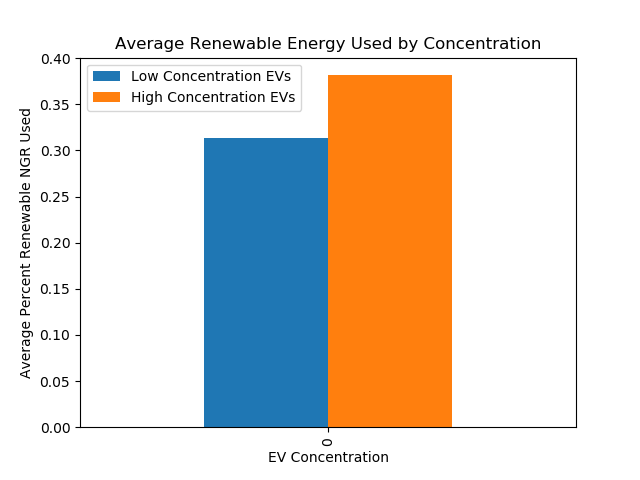

In [164]:
#Create Bar chart of averages
renew_pect = pd.DataFrame({"Low Concentration EVs": [bottomEVaverage], 
                           "High Concentration EVs": [topEVaverage]})

renew_pect
chart = renew_pect.plot(kind='bar', title = 'Average Renewable Energy Used by Concentration')
chart.set_xlabel("EV Concentration")
chart.set_ylabel("Average Percent Renewable NGR Used")
plt.savefig('../output/energy_concentration.png')

In [165]:
#Create a pie chart of energy use in CA
Coal = 0
Large_Hydro = 0
Natural_Gas = 0
Nuclear = 0
Oil = 0
Other = 0
Renewables = 0
Unspecified = 0


for i in range(len(df_energy)):
    Coal += df_energy.iloc[i,1]
    Large_Hydro += df_energy.iloc[i,2]
    Natural_Gas += df_energy.iloc[i,3]
    Nuclear += df_energy.iloc[i,4]
    Oil += df_energy.iloc[i,5]
    Other += df_energy.iloc[i,6]
    Renewables += df_energy.iloc[i,7]
    Unspecified += df_energy.iloc[i,8]
    
print(Coal)
print(Large_Hydro)
print(Natural_Gas)
print(Nuclear)
print(Oil)
print(Other)
print(Renewables)
print(Unspecified)

9793.810000000001
28940.770000000004
92865.02
26640.360000000004
36.04999999999998
420.86000000000007
98775.59999999999
26951.430000000004


<IPython.core.display.Javascript object>


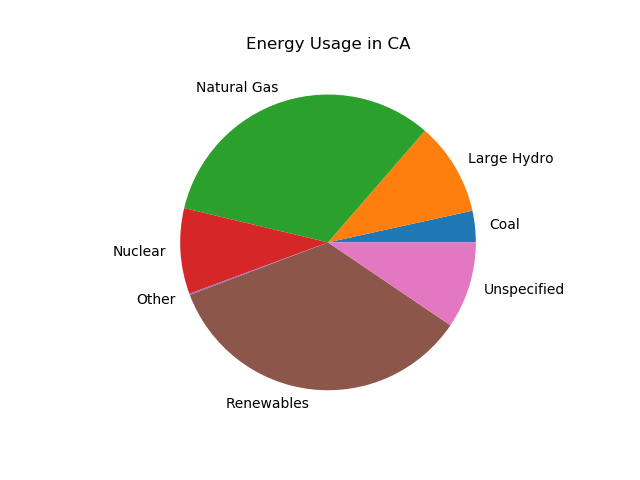

In [166]:
pie_df = pd.DataFrame({"Usage": [Coal,
                               Large_Hydro,
                               Natural_Gas,
                               Nuclear,
                               Other,
                               Renewables,
                               Unspecified]},
                      index = ["Coal", 
                              "Large Hydro", 
                              "Natural Gas", 
                              "Nuclear",  
                              "Other", 
                              "Renewables",
                              "Unspecified"])
                      

pie_chart = pie_df.plot.pie(y="Usage", legend = None)

pie_chart.set_ylabel("")
pie_chart.set_title("Energy Usage in CA")

plt.savefig('../output/energy_pie.png')
